In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import logging

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    SPLIT,
    DEVELOP,
    TEST
)

sns.set_style("darkgrid")
matplotlib.rcParams['font.family'] = "serif"
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


In [3]:
features = Features(config)
df_features = features.build(df)

2022-11-12 18:04:05,041 - capstone.utils.utils - INFO - func:clean took: 3.09 sec
2022-11-12 18:04:05,661 - capstone.utils.utils - INFO - func:fit took: 3.71 sec
2022-11-12 18:04:07,308 - capstone.utils.utils - INFO - func:clean took: 1.65 sec
2022-11-12 18:04:07,527 - capstone.utils.utils - INFO - func:transform took: 1.87 sec
2022-11-12 18:04:07,528 - capstone.utils.utils - INFO - func:fit_transform took: 5.57 sec
2022-11-12 18:04:07,709 - capstone.utils.utils - INFO - func:clean took: 0.18 sec
2022-11-12 18:04:07,735 - capstone.utils.utils - INFO - func:transform took: 0.21 sec
2022-11-12 18:04:07,761 - capstone.utils.utils - INFO - func:build took: 5.82 sec


In [4]:
df_features.head(3)

,Text,Standard mapping?,Original Text,audit inspection,calibration,capa,change controls,clinical research,controled substances,csv,...,word__unit generally,word__unit generally shared,word__use device,word__used manufacture,word__used production,word__validation study,word__way ensures,word__wholesale distributor,word__written procedure,Split
0,good practice quality control qc responsibilit...,"[laboratory controls, stability programs]",Good practices in quality control […] Other QC...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.439675,Development
1,good practice quality control basic requiremen...,"[capa, nc, rca]",Good practices in quality control […] The basi...,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Development
2,validation process validation program critical...,[process & packaging validation],Validation […] Process Validation Program […] ...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.285952,0.0,0.0,0.000000,Development


In [5]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
X_dev = dev[features.vectorizer.get_feature_names_out()].copy()
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
X_test = test[features.vectorizer.get_feature_names_out()].copy()
Y_test = test[features.mlb.classes_].copy()

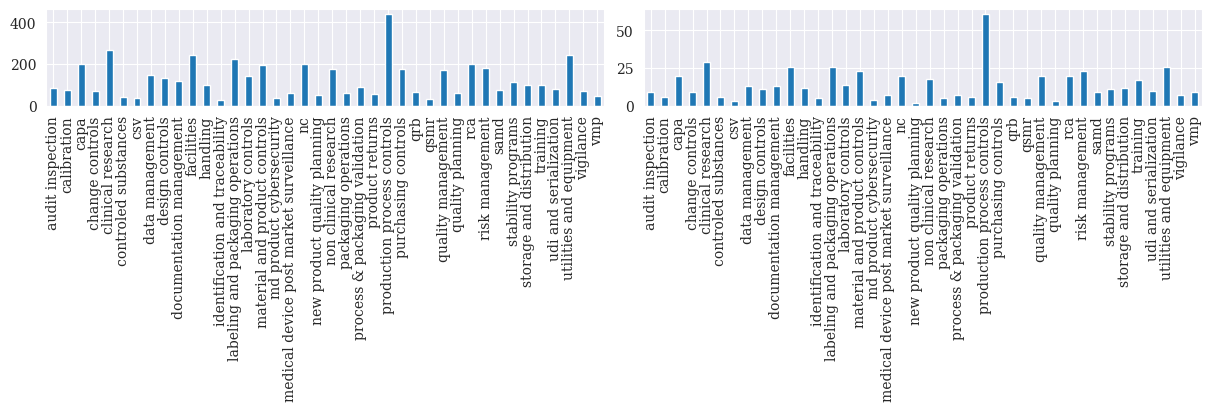

In [6]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
Y_dev.sum(axis=0).plot.bar(ax=ax[0]);
Y_test.sum(axis=0).plot.bar(ax=ax[1]);

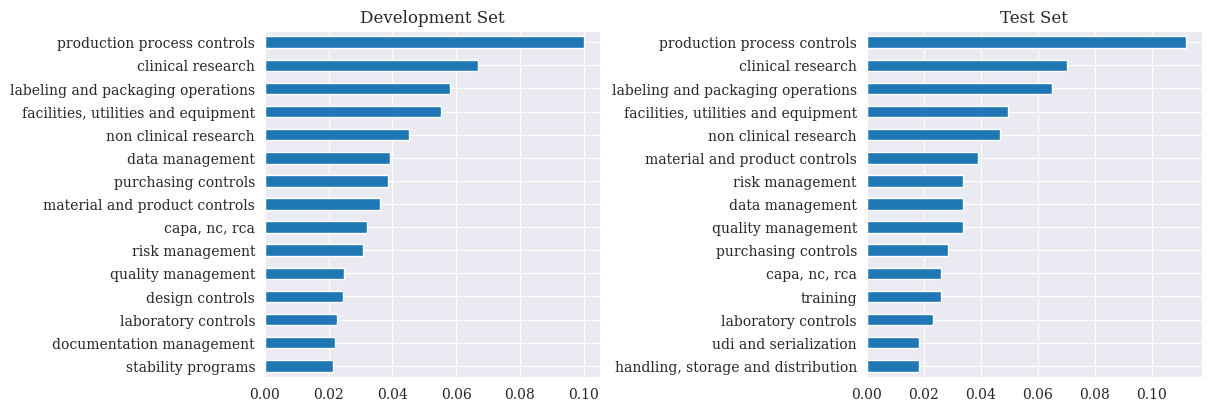

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

dev[TARGET] \
.apply(lambda x: ", ".join(sorted(x))) \
.value_counts(normalize=True) \
.head(15) \
.sort_values() \
.plot(kind="barh", ax=ax[0])

test[TARGET] \
.apply(lambda x: ", ".join(sorted(x))) \
.value_counts(normalize=True) \
.head(15) \
.sort_values() \
.plot(kind="barh", ax=ax[1])

ax[0].set_title("Development Set")
ax[1].set_title("Test Set")
plt.show();

In [8]:
eval = CustomEvaluation()

Naive Model - Predict the most popular target (binary vector) in the development set

In our case, the most popular development target matches the most popular test target.

In [9]:
most_popular = \
    dev.groupby(by=features.mlb.classes_.tolist(), as_index=False) \
    .size() \
    .sort_values(by="size", ascending=False) \
    .apply(lambda row: np.array(row[features.mlb.classes_.tolist()]), axis=1) \
    .values[0]

print(
    "Most popular binary vector in development set:",
    features.mlb.inverse_transform(most_popular.reshape(1, -1))
)

Y_test_pred = np.tile(most_popular, (Y_test.shape[0] , 1))

Most popular binary vector in development set: [('production process controls',)]


In [10]:
eval.compute_sample_wise_metrics(y_true=Y_test.to_numpy(), y_pred=Y_test_pred)

Hamming Loss    0.052799
Accuracy        0.111979
Precision       0.158854
Recall          0.128668
F1 Score        0.135995
dtype: float64

In [11]:
cmat = eval.compute_multilabel_confusion_matrix(
    y_true=Y_test.to_numpy(), y_pred=Y_test_pred, labels=features.mlb.classes_
)
cmat.style.set_table_styles(config.CONFUSION_MATRIX_STYLER)

/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:73: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  pd.DataFrame(x)
/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:73: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='columns')`
  pd.DataFrame(x)
/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:82: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  pd.DataFrame(np.array([["TN", "FP"], ["FN", "TP"]]))
/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:82: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='columns')`
  pd.DataFrame(np.array([["TN", "FP"], ["FN", "TP"]]))


In [12]:
eval.compute_label_wise_metrics(
    y_true=Y_test.to_numpy(),
    y_pred=Y_test_pred,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,Development Samples,Test Samples
audit inspection,0.000000,0.0,0.000000,86,9
calibration,0.000000,0.0,0.000000,78,6
capa,0.000000,0.0,0.000000,202,20
change controls,0.000000,0.0,0.000000,71,9
clinical research,0.000000,0.0,0.000000,269,29
controled substances,0.000000,0.0,0.000000,40,6
csv,0.000000,0.0,0.000000,37,3
data management,0.000000,0.0,0.000000,150,13
design controls,0.000000,0.0,0.000000,132,11
documentation management,0.000000,0.0,0.000000,117,13
